In [2]:
import os
import numpy as np
import pandas as pd
import biom
from biom import Table
import matplotlib.pyplot as plt
import csv

### 新添加的样本数

In [3]:
metadata = pd.read_csv("../../data/Pretraining_data_profile/gut_dada2_add.txt", sep = "\t", index_col=0, dtype="str", quoting=csv.QUOTE_NONE)

In [4]:
metadata.shape

(3137, 10)

In [9]:
len(metadata.BioProject.unique())

6

### quality control

In [868]:
filter_keeping_sample = []
for name in metadata.BioProject.unique():
    summary = pd.read_csv(f"/home/dongbiao/word_embedding_microbiome/all_data/gut/biom_gut/{name}/results/summary.tsv", sep="\t", dtype="str")
    filter_keeping_sample = filter_keeping_sample + summary.iloc[:, 0].tolist()

In [869]:
filter_keeping_sample = [i.split('_1.fastq')[0] for i in filter_keeping_sample]
filter_keeping_sample = [i.split('_1.fq.gz')[0] for i in filter_keeping_sample]
filter_keeping_sample = [i.split('.fastq')[0] for i in filter_keeping_sample]

In [870]:
inter_id = np.intersect1d(filter_keeping_sample, metadata.index.values)

In [871]:
metadata_quality_control = metadata.loc[inter_id]

In [872]:
metadata_quality_control.shape

(84449, 10)

In [873]:
len(metadata_quality_control.BioProject.unique())

259

### DADA2 filter

In [874]:
study_id = metadata_quality_control.BioProject.unique()
chim_perc_rate = []
for name in study_id:
    summary_dada2 = pd.read_csv(f"/home/dongbiao/word_embedding_microbiome/all_data/gut/biom_gut/{name}/results/summary.tsv", 
                                index_col=0, sep="\t")
    summary_dada2.index = [str(i) for i in summary_dada2.index.values]
    summary_dada2.index = [i.split(".fastq")[0] for i in summary_dada2.index.values]
    chim_perc_rate.append(sum(summary_dada2.chim_perc.values > 25) / summary_dada2.shape[0])

study_chim_perc_rate = pd.DataFrame({"study_id":study_id, "chim_perc_rate":chim_perc_rate})
study_filter = study_chim_perc_rate.loc[study_chim_perc_rate.chim_perc_rate.values < 0.3]

In [875]:
study_filter.shape

(244, 2)

In [876]:
metadata_dada2 = metadata_quality_control.loc[[i in study_filter.study_id.values for i in metadata_quality_control.BioProject.values]]

In [887]:
len(np.unique(metadata_dada2.BioProject.unique()))

244

In [883]:
metadata_dada2.shape

(83839, 10)

### close reference filter

In [888]:
ratio = []
sid = metadata_dada2.index.values
study_id = metadata_dada2.BioProject.unique()
for name in study_id:
    table = biom.load_table(f"/home/dongbiao/word_embedding_microbiome/all_data/gut/biom_gut/{name}/results/ASVs_counts.biom")
    inter_id = np.intersect1d(table.ids(axis="sample"), sid)
    table = table.filter(inter_id)
    totall_1 = np.sum(table.sum(axis='sample'))

    table = biom.load_table(f"/home/dongbiao/word_embedding_microbiome/all_data/gut/biom_gut/{name}/results/extracted-feature-table/feature-table.biom")
    inter_id = np.intersect1d(table.ids(axis="sample"), sid)
    table = table.filter(inter_id)
    totall_2 = np.sum(table.sum(axis='sample'))

    ratio.append(totall_2 / totall_1)

In [889]:
ratio = np.array(ratio)

In [890]:
keep_res = pd.DataFrame({"study_id":study_id, "ratio":ratio})

Text(0, 0.5, 'Density')

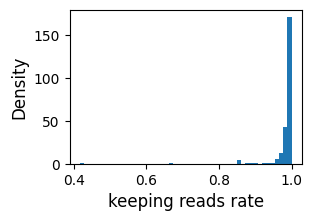

In [891]:
plt.figure(figsize=(3, 2))
plt.hist(ratio, bins=50)
plt.xlabel('keeping reads rate', fontsize=12)
plt.ylabel('Density', fontsize=12)

In [930]:
study_id_filter = study_id[ratio>0.89]

In [912]:
filter_table

,study_id,ratio
52,PRJEB24771,0.852627
63,PRJEB28485,0.855999
81,PRJEB34394,0.873373
139,PRJNA445932,0.418232
164,PRJNA762360,0.855428
179,PRJNA417579,0.671462
197,PRJNA379437,0.855221
226,PRJNA480674,0.887510


In [900]:
metadata_close_reference = metadata_dada2.loc[[i in study_id_filter for i in metadata_dada2.BioProject.values]]

In [901]:
len(metadata_close_reference.BioProject.unique())

236

In [902]:
metadata_close_reference.shape

(76823, 10)

In [903]:
n = 1
sid = metadata_close_reference.index.values
for i in metadata_close_reference.BioProject.unique():
    if n == 1:
        table = biom.load_table(f"/home/dongbiao/word_embedding_microbiome/all_data/gut/biom_gut/{i}/results/extracted-feature-table/feature-table.biom")
        inter_id = np.intersect1d(table.ids(axis="sample"), sid)
        table = table.filter(inter_id)
    else:
        temp = biom.load_table(f"/home/dongbiao/word_embedding_microbiome/all_data/gut/biom_gut/{i}/results/extracted-feature-table/feature-table.biom")
        inter_id = np.intersect1d(temp.ids(axis="sample"), sid)
        temp = temp.filter(inter_id)
        table = table.merge(temp)
    n = n + 1
table.remove_empty()

81298 x 76546 <class 'biom.table.Table'> with 10748397 nonzero entries (0% dense)

In [904]:
inter_id = np.intersect1d(table.ids(axis="sample"), metadata_close_reference.index.values)

In [905]:
metadata_close_reference = metadata_close_reference.loc[inter_id]
table = table.filter(inter_id, axis="sample")

In [906]:
with biom.util.biom_open(f"/home/dongbiao/word_embedding_microbiome/all_data/gut/complete_data_add/table_add.biom", 'w') as f:
    table.to_hdf5(f, 'example')

In [907]:
metadata_close_reference.to_csv("/home/dongbiao/word_embedding_microbiome/all_data/gut/complete_data_add/metadata_add.txt", sep="\t")

In [908]:
metadata_close_reference.Site.unique()

array(['feces', 'stool'], dtype=object)

In [909]:
metadata_close_reference.shape

(76546, 10)

In [910]:
len(metadata_close_reference.BioProject.unique())

236